# Tuned Sentiments

## API Call, Web Scraping and Cleaning

#### Details except the lyrics, is collected for the top 100 songs for each year from 2000 to 2019. 
#### Musixmatch's track.search API is used to accomplish this. Using the url obtained from this API, webpage is scraped for the lyrics of each track. 

In [2]:
import requests
import pandas as pd
import numpy as np
import random
import re
import itertools
from bs4 import BeautifulSoup
import time
from IPython.display import clear_output
import cfscrape
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import signal
from wordcloud import WordCloud
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from PIL import Image
import statsmodels.api as sm
import warnings
import datetime as dt

# Remove all warnings
warnings.filterwarnings('ignore')

# Define the local filepath
filepath = "C:/Users/Avinav/UMD/Sem 1/BUDT758X-0502 Data Processing and Analysis in Python/Project/"

# Fetches data given a particular API and its parameters
def get_data(api, params = {}):
    base_url = "https://api.musixmatch.com/ws/1.1/"
    # Add the API relative path to the sites base URL
    url = base_url + api
    # Add authentication key in the parameters
    params["apikey"] = "b3a9c0d85325a49c7a10d5bd1f646fed"
    # Make the API call and convert the response into JSON format
    request_object = requests.get(url = url, params = params)
    return request_object.json()

In [3]:
scraper = cfscrape.create_scraper()

# This function returns all the details of the top 100 songs for a given year, in the form of a dataframe
def get_track_details(year):
    # Set the starting and ending date for that year
    min_date = str(year) + '0101'
    max_date = str(year) + '3112'
    track_params = {
      "f_track_release_group_first_release_date_min": min_date,
      "f_track_release_group_first_release_date_max": max_date,
      "s_track_rating": "desc",
      "page_size": 100
    }
    # Get json data for top 100 tracks of 2019
    tracks_json = get_data("track.search", track_params)
    # Extract the list of tracks details from this json
    tracks_json_list = tracks_json["message"]["body"]["track_list"]
    #tracks_json_list = tracks_json_list[]
    tracks_list = []

    # Extract relevant data from the tracks lists and append it to a new list
    for index, track in enumerate(tracks_json_list):
        # Initialize a variable which will store the lyrics of the track
        lyrics = ""

        clear_output(wait=True)
        print("Please wait. Fetching year- " + str(year) + " track-", index + 1)

        # Scrape lyrics from each of the track url
        track_url = track["track"]["track_share_url"]
        #print(track_url)
        #track_page = requests.get(track_url, headers)
        track_page = scraper.get(track_url)
        track_page_soup = BeautifulSoup(track_page.text, 'html.parser')
        #print(track_page)
        #print(track_page_soup)
        # Check if the page contains buttons to transalte the lyrics to english
        eng_button = track_page_soup.find_all(name='i', class_='en-us-flag')

        # If the page contains a button for translating the lyrics, scrape from a new page
        if len(eng_button) > 0:
            # Wait half a second to avoid being blocked as a scrapper
            #time.sleep(0.5)

            # Scrape lyrics from english translated page
            track_url_parts = track_url.split("?")
            track_url = track_url_parts[0] + '/translation/english?' + track_url_parts[1]
            #print(track_url)
            #track_page = requests.get(track_url, headers)
            track_page = scraper.get(track_url)
            track_page_soup = BeautifulSoup(track_page.text, 'html.parser')
            #print(track_page_soup)
            # Find all the divs containing the class "mxm-translatable-line-readonly"
            lyrics_container = track_page_soup.find_all(name='div', class_='mxm-translatable-line-readonly')

            # From each of these divs, get the lyrics line and append it to the "lyrics" variable
            for container in lyrics_container:
                container_txt = container.find_all(name='div', class_='col-xs-6')[1].text
                lyrics = lyrics + " " + container_txt.lower()
        else:
            # Find all the p tags containing the class "lyrics__content__ok"
            lyrics_container = track_page_soup.find_all(name='p', class_='mxm-lyrics__content')
            # From each of the spans, extract the lyrics and append it to the "lyrics" variable
            for container in lyrics_container:
                lyrics = lyrics + " " + container.text.lower()

        # Wait half a second to avoid being blocked as a scrapper
        #time.sleep(0.5)
        
        # Find out the track genre, if no genre then include it as "Pop"
        genre_list = track["track"]["primary_genres"]["music_genre_list"]
        genre = "Pop"
        if len(genre_list) > 0:
            genre = genre_list[-1]["music_genre"]["music_genre_name"]

        # Append a dictionary of track details along with the lyrics to the initialized list
        tracks_list.append({
            "track_id": track["track"]["track_id"],
            "track_name": track["track"]["track_name"],
            "track_rating": track["track"]["track_rating"],
            "track_url": track_url,
            "lyrics": lyrics,
            "genre": genre,
            "artist_name": track["track"]["artist_name"],
            "artist_id": track["track"]["artist_id"],
            "album_name": track["track"]["album_name"],
            "album_id": track["track"]["album_id"]
        })

    # Clear the last output
    clear_output()

    # Create a dataframe of the tracks details
    tracks_df = pd.DataFrame(tracks_list, columns = [
        "track_id", 
        "track_name", 
        "track_rating",
        "track_url",
        "lyrics",
        "genre",
        "artist_name",
        "artist_id",
        "album_name",
        "album_id"
    ])

    # Remove the new line characters from the lyrics
    tracks_df["lyrics"] = tracks_df["lyrics"].str.replace("\n", " ")

    # Remove numbers and undesirable special characters from the lyrics
    regex = re.compile('[0-9*".\/()]')
    tracks_df["lyrics"] = tracks_df["lyrics"].map(lambda lyrics: regex.sub('', lyrics))

    # Convert "Music" genre to "Pop", as suggested by the musixmatch site
    tracks_df["genre"] = tracks_df["genre"].replace("Music", "Pop")

    return tracks_df

#### All the track details, including the lyrics, is stored locally in csv files by year, after cleaning the data.

In [ ]:
# Fetch top 100 track details for years 2000 to 2019 and store them in different CSV files
for year in range(2000, 2020):
    df = get_track_details(year)
    filename = filepath + 'lyrics_' + str(year) + '.csv'
    # Use "|" to seperate the values of each record and store as csv
    df.to_csv(filename, sep="|")

## Cleaning, Word Processing and Sentiment Analysis

#### Data is further cleaned and processed to get meaningful and usable words for sentiment analysis. Sentiment analysis is based on the standard of NRC emotion lexicon library to associate sentiment to each word.

In [4]:
# Create the Lemmatizataion object
lmtzr = WordNetLemmatizer()

# Get the NRC lexicon data
emolex_filename = filepath + "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
emolex_df = pd.read_csv(emolex_filename, names=["word", "emotion", "flag"], sep="\t")
emolex_df.head()

,word,emotion,flag
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0


In [5]:
# This function returns all the words of all the lyrics of a particular year's dataframe
# after processing the words and filtering out non-sentimental words
def get_processed_words(df):
    # Remove numbers and undesirable special characters from the lyrics
    regex = re.compile('[0-9*".\/()|,]')
    df["lyrics"] = df["lyrics"].map(lambda lyrics: regex.sub('', lyrics))

    # Remove all the lyrics which do not have an english translation
    df.lyrics = df.lyrics.str.replace('[^a-z\' ]', '')

    # Initialize a list to store all the words in lyrics for the current year
    cy_word_tokens = []

    for index, row in df.iterrows():
        lyrics = row["lyrics"]
        words_list = lyrics.split()

        # Remove all the stop words
        words_list = [word for word in words_list if word not in stopwords.words('english')]

        # Lemmatizataion
        words_list = [lmtzr.lemmatize(word) for word in words_list]

        # Remove duplicate words from each lyrics
        words_list = list(set(words_list))

        # Append these words to the list of all the words for current year
        cy_word_tokens.extend(words_list)

    # Remove the non-senitmental words from the current year word list
    unique_emolex = emolex_df.word.unique()
    cy_word_tokens = [word for word in cy_word_tokens if word in unique_emolex]
    
    return cy_word_tokens

In [6]:
# Initialize a list to store the processed words for each year
pw_by_year = []

# Initialize an empty list to store all the dataframes read from the csv files
dfs = []

# Read the csv files created for processing
for year in range(2000, 2020):
    clear_output(wait=True)
    print("Please wait. Processing words for year " + str(year))
    
    input_file = filepath + "Scraped/lyrics_" + str(year) + ".csv"
    df = pd.read_csv(input_file, sep="|")
    
    # Drop the first column of default indices
    df = df.drop(columns = ["Unnamed: 0"])
    # Convert data types of object columns to string
    df[['track_name',
        'track_url',
        'lyrics',
        'genre',
        'artist_name',
        'album_name']] = df[['track_name', 'track_url', 'lyrics', 'genre', 'artist_name', 'album_name']].astype(str)
    dfs.append(df)
    pw_by_year.append(get_processed_words(df))
    
clear_output(wait=True)
len(pw_by_year)

20

In [7]:
# Sample dataframe for the year 2010
dfs[10].head()

,track_id,track_name,track_rating,track_url,lyrics,genre,artist_name,artist_id,album_name,album_id
0,39682680,My Body,91,https://www.musixmatch.com/lyrics/Young-the-Gi...,stop the train is ridin down to the station w...,Alternative,Young the Giant,13127264,Young the Giant,13127279
1,73437257,Just the Way You Are,89,https://www.musixmatch.com/lyrics/Bruno-Mars/J...,oh her eyes her eyes make the stars look like...,Contemporary R&B,Bruno Mars,33492237,Doo-Wops & Hooligans,19648717
2,18470707,Rolling in the Deep,89,https://www.musixmatch.com/lyrics/Adele-3/Roll...,there's a fire starting in my heart reaching ...,Pop,Adele,346898,21,13853441
3,12964664,Christmas Lights,89,https://www.musixmatch.com/lyrics/Coldplay/Chr...,christmas night another fight tears we cried ...,Pop,Coldplay,1039,Christmas Lights,12964814
4,17099576,Pumped Up Kicks,87,https://www.musixmatch.com/lyrics/Foster-the-P...,robert's got a quick hand he'll look around t...,Alternative,Foster the People,11225398,Torches,13869728


In [8]:
# Pivot the NRC dataframe to get a dataframe of unique words
emolex_words = emolex_df.pivot(index='word', columns='emotion', values='flag').reset_index()

# This function returns a datframe of words containing their 
# associated sentiments and emotions as columns
def get_emolex_words(words):
    # Initialize an empty list to store dataframes of emolex words
    emolex_df_list = []

    # Get dataframes of those words which were used in lyrics of 2019 songs
    for word in words:
        emolex_df_list.append(emolex_words[emolex_words["word"] == word])

    return pd.concat(emolex_df_list)

In [9]:
# Get the emolex words for year 2019
emolex_2019 = get_emolex_words(pw_by_year[19])
emolex_2019.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
3184,dear,0,0,0,0,0,0,1,0,0,0
12713,thing,0,0,0,0,0,0,0,0,0,0
12179,style,0,0,0,0,0,0,0,0,0,0
3017,cry,0,0,0,0,0,1,0,1,0,0
963,ay,0,0,0,0,0,0,1,0,0,0


In [84]:
# Get the frequency of each of the sentiments and emotions
sentiment_sum = emolex_2019.sum(skipna = True)
sentiment_sum = sentiment_sum.iloc[1:].sort_values(ascending=False)
# Find the percentage of words used for each sentiment
factor = 100/len(emolex_2019.index)
sentiment_percentage = sentiment_sum.multiply(other = factor)

fig = go.Figure(data = [go.Bar(
    x=sentiment_percentage.index, 
    y=sentiment_percentage.values,
    marker={'color': ['rgb(86, 80, 250)', 
                      'rgb(252, 65, 58)',
                      'rgb(0, 114, 90)',
                      'rgb(248, 100, 15)',
                      'rgb(246, 214, 117)',
                      'rgb(142, 189, 248)',
                      'rgb(255, 123, 179)',
                      'rgb(0, 214, 101)',
                      'rgb(255, 166, 0)',
                      'rgb(0, 204, 236)'
                     ]}
)])
fig.update_layout(
    xaxis_title="Sentiments and Emotions",
    yaxis_title="Percentage of words",
    title="Emotional trend for songs in 2019",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    template="plotly_white"
    )
fig.show()

#### The above graph shows sentiment (positive and negative) and emotions (joy, trust, anticipation, fear, sadness, anger, surprise and disgust) associated with top 100 songs of 2019. Looking at it, we can conclude that a positive sentiment was more associated with the songs of 2019 with "joy" being the most popular emotion of these songs.

In [11]:
# Read an image and create a mask for it
img_mask = np.array(Image.open(filepath + 'wordcloud.png'))

# Transform all the mask values to 255 if it is 1
def transform_format(val):
    if val == 1:
        return 255
    else:
        return val
    
# Transform your mask into a new one that will work with the word cloud module
transformed_img_mask = np.ndarray((img_mask.shape[0],img_mask.shape[1]), np.int32)
for i in range(len(img_mask)):
    transformed_img_mask[i] = list(map(transform_format, img_mask[i]))

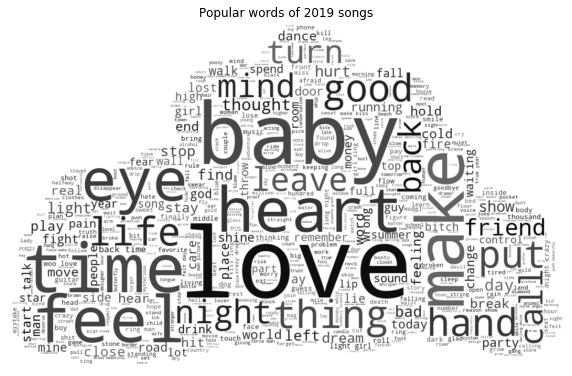

In [12]:
# Generate shades of black by using random numbers
def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(0, 40)

# Create the word cloud using the mask created
wc = WordCloud(background_color='white', max_words=1000, mask=transformed_img_mask)
wc.generate(' '.join(pw_by_year[19]))
plt.figure(figsize=(10,10))
plt.imshow(wc.recolor(color_func=black_color_func, random_state=3), interpolation="bilinear")
plt.axis("off")
plt.title('Popular words of 2019 songs');

#### Above diagram depicts a word cloud of the words used in the top 100 songs of 2019. We can see that love, baby, feel and time are some of the most frequently used words in these songs which was expected based on our general knowledge of the songs over the years.

In [13]:
# Divide the dataframes into 2 decades - 2000-2010 and 2011-2019
decade1_dfs = pd.concat(dfs[:11])
decade2_dfs = pd.concat(dfs[11:])

# Initialize an empty list that will store processed words for each decade as a list
pw_by_decade = []

# Get the processed words for each decade
pw_by_decade.append(get_processed_words(decade1_dfs))
pw_by_decade.append(get_processed_words(decade2_dfs))

In [14]:
# Make a list of  popular genres to select the sentiments from
pop_genre = ["Alternative", "Dance", "Electronic", "Hip Hop/Rap", "Latin", "Pop", "Rock", "World"]

# Initialize list to store the dictionaries containing sentiment details for each decade
decade_list = []

for index, decade_df in enumerate([decade1_dfs, decade2_dfs]):
    # Create a dictionary to store genre names and sentiments for each of these genres
    genre_dict = {
        "anger": [],
        "anticipation": [],
        "disgust": [],
        "fear": [],
        "joy": [],
        "negative": [],
        "positive": [],
        "sadness": [],
        "surprise": [],
        "trust": [],
        "genre": []
    }
    decade = str(index + 1)
    
    # Get sentiments for each of the genres
    decade_grouped = decade_df.groupby(by="genre")
    for genre_name, group in decade_grouped:
        if genre_name in pop_genre:
            # Create a copy of the group to avoid hampering the original dataframe
            group_copy = group.copy()
            
            clear_output(wait=True)
            print("Please wait. Processing words for decade: " + decade + ", genre: " + genre_name)
            
            pw_by_genre = get_processed_words(group_copy)
            # Check if there are processed words in a particular genre or not
            if len(pw_by_genre) > 0:
                emolex_genre = get_emolex_words(pw_by_genre)
                # Get the frequency of each of the sentiments and emotions
                sentiment_sum = emolex_genre.sum(skipna = True)
                sentiment_sum = sentiment_sum.iloc[1:].sort_values(ascending=False)
                # Find the percentage of words used for each sentiment
                factor = 100/len(emolex_genre.index)
                sentiment_percentage = sentiment_sum.multiply(other = factor)
                # Append the genre name in the dictionary with key "genre"
                genre_dict["genre"].append(genre_name)
                # Append each value of the sentiment percentage in the appropriate sentiment key in the dictionary
                for index, percentage in sentiment_percentage.items():
                    genre_dict[index].append(round(percentage, 2))
                    
    clear_output()
    decade_list.append(genre_dict)

In [15]:
decade_list

[{'anger': [8.95, 8.53, 7.56, 10.09, 6.51, 7.14, 9.66, 8.34],
  'anticipation': [11.17, 10.77, 12.89, 9.17, 12.2, 11.9, 11.09, 13.37],
  'disgust': [7.04, 5.21, 4.89, 6.78, 3.52, 5.05, 6.45, 5.71],
  'fear': [12.38, 9.25, 6.67, 10.45, 10.63, 8.63, 11.79, 9.37],
  'joy': [10.54, 12.93, 13.33, 8.82, 14.07, 12.85, 10.95, 13.03],
  'negative': [21.68, 16.79, 16.89, 19.62, 19.31, 16.43, 20.87, 19.66],
  'positive': [18.07, 19.66, 19.56, 16.97, 22.75, 20.74, 18.24, 22.4],
  'sadness': [12.87, 8.35, 10.67, 9.72, 12.57, 9.46, 12.51, 10.86],
  'surprise': [5.87, 7.72, 5.78, 5.9, 6.66, 6.77, 6.48, 5.83],
  'trust': [11.46, 11.94, 11.56, 10.93, 11.98, 11.84, 11.59, 11.31],
  'genre': ['Alternative',
   'Dance',
   'Electronic',
   'Hip Hop/Rap',
   'Latin',
   'Pop',
   'Rock',
   'World']},
 {'anger': [7.79, 8.54, 9.22, 10.91, 8.24, 8.26, 7.93, 7.09],
  'anticipation': [11.39, 9.81, 11.11, 10.03, 8.24, 11.37, 13.26, 12.2],
  'disgust': [6.08, 5.22, 5.91, 7.77, 4.66, 5.32, 4.61, 6.69],
  'fear': 

In [85]:
# Create a grouped bar graph of sentiments for the 1st decade
genre_dict1 = decade_list[0]
fig = go.Figure()
fig.add_trace(go.Bar(name='positive', x=genre_dict["genre"], y=genre_dict1["positive"], marker={'color': 'rgb(86, 80, 250)'}))
fig.add_trace(go.Bar(name='negative', x=genre_dict["genre"], y=genre_dict1["negative"], marker={'color': 'rgb(252, 65, 58)'}))
fig.add_trace(go.Bar(name='joy', x=genre_dict["genre"], y=genre_dict1["joy"], marker={'color': 'rgb(0, 114, 90)'}))
fig.add_trace(go.Bar(name='anticipation', x=genre_dict["genre"], y=genre_dict1["anticipation"], marker={'color': 'rgb(248, 100, 15)'}))
fig.add_trace(go.Bar(name='trust', x=genre_dict["genre"], y=genre_dict1["trust"], marker={'color': 'rgb(246, 214, 117)'}))
fig.add_trace(go.Bar(name='sadness', x=genre_dict["genre"], y=genre_dict1["sadness"], marker={'color': 'rgb(142, 189, 248)'}))
fig.add_trace(go.Bar(name='fear', x=genre_dict["genre"], y=genre_dict1["fear"], marker={'color': 'rgb(255, 123, 179)'}))
fig.add_trace(go.Bar(name='anger', x=genre_dict["genre"], y=genre_dict1["anger"], marker={'color': 'rgb(0, 214, 101)'}))
fig.add_trace(go.Bar(name='surprise', x=genre_dict["genre"], y=genre_dict1["surprise"], marker={'color': 'rgb(255, 166, 0)'}))
fig.add_trace(go.Bar(name='disgust', x=genre_dict["genre"], y=genre_dict1["disgust"], marker={'color': 'rgb(0, 204, 236)'}))

# Change the graph layout
fig.update_layout(
    barmode='group',
    title="Sentiment and Emotions - 2000 to 2010",
    xaxis_title="Popular Genres",
    yaxis_title="Percentage of words",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    template="plotly_white"
)
fig.show()

#### The above graph shows us the sentiments and emotions associated with songs from the year 2000 to 2019, according to some popular genres. As can be guessed, negative sentiment is highly associated with genres like Hip Hop/Rap, Rock and Alternative whereas Dance and Electronic genres have more of a positive sentiment associated with them.
#### Positive sentiment and emotion - joy dominates in Latin genre whereas sadness dominates the songs of the Alternative genre. Anger is an emotion found the most frequently in the Hip Hop/Rap genre, which can be verified from this graph.

In [86]:
# Create a grouped bar graph of sentiments for the 2nd decade
genre_dict2 = decade_list[1]
fig = go.Figure()
fig.add_trace(go.Bar(name='positive', x=genre_dict["genre"], y=genre_dict1["positive"], marker={'color': 'rgb(86, 80, 250)'}))
fig.add_trace(go.Bar(name='negative', x=genre_dict["genre"], y=genre_dict1["negative"], marker={'color': 'rgb(252, 65, 58)'}))
fig.add_trace(go.Bar(name='joy', x=genre_dict["genre"], y=genre_dict1["joy"], marker={'color': 'rgb(0, 114, 90)'}))
fig.add_trace(go.Bar(name='anticipation', x=genre_dict["genre"], y=genre_dict1["anticipation"], marker={'color': 'rgb(248, 100, 15)'}))
fig.add_trace(go.Bar(name='trust', x=genre_dict["genre"], y=genre_dict1["trust"], marker={'color': 'rgb(246, 214, 117)'}))
fig.add_trace(go.Bar(name='sadness', x=genre_dict["genre"], y=genre_dict1["sadness"], marker={'color': 'rgb(142, 189, 248)'}))
fig.add_trace(go.Bar(name='fear', x=genre_dict["genre"], y=genre_dict1["fear"], marker={'color': 'rgb(255, 123, 179)'}))
fig.add_trace(go.Bar(name='anger', x=genre_dict["genre"], y=genre_dict1["anger"], marker={'color': 'rgb(0, 214, 101)'}))
fig.add_trace(go.Bar(name='surprise', x=genre_dict["genre"], y=genre_dict1["surprise"], marker={'color': 'rgb(255, 166, 0)'}))
fig.add_trace(go.Bar(name='disgust', x=genre_dict["genre"], y=genre_dict1["disgust"], marker={'color': 'rgb(0, 204, 236)'}))

# Change the graph layout
fig.update_layout(
    barmode='group',
    title="Sentiment and Emotions - 2010 to 2019",
    xaxis_title="Popular Genres",
    yaxis_title="Percentage of words",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    template="plotly_white"
)
fig.show()

#### The above graph shows us the same results as the earlier graph for the years 2010 to 2019. Comparing the 2 graphs we can conclude that the trend over the years has not changed by much. However, overall we can se a slight decrease in the negative sentiments across the genres, except for Hip Hop/Rap where the negativity has increased. Furthermore, the positive sentiment has slightly increased in the second decade as compared to the first decade.

In [18]:
# Initialize a list to store the sentiment percentage words for each year as a dataframe
sentiment_list = []
year = 2000
for pw in pw_by_year:
    emolex_df = get_emolex_words(pw)
    # Get the frequency of each of the sentiments and emotions
    sentiment_sum = emolex_df.sum(skipna = True)
    sentiment_sum = sentiment_sum.iloc[1:].sort_values(ascending=False)
    # Find the percentage of words used for each sentiment
    factor = 100/len(emolex_df.index)
    sentiment_percentage = sentiment_sum.multiply(other = factor)
    sentiment_list.append(pd.DataFrame([sentiment_percentage.values], index=[year], columns=sentiment_percentage.index))
    year = year + 1
sentiment_df = pd.concat(sentiment_list, sort=False)
sentiment_df

,negative,positive,joy,trust,fear,sadness,anticipation,anger,disgust,surprise
2000,20.359450,18.899186,11.092390,10.783488,10.586914,10.278012,10.193766,9.856782,7.329402,5.869138
2001,17.954298,19.695321,11.679362,11.824447,10.337323,11.062749,11.606819,7.544432,5.259340,5.948495
2002,19.637166,19.759745,10.983084,11.154695,10.762442,10.492768,11.203726,8.948272,6.447659,5.981858
2003,20.045645,19.969570,12.818562,13.198935,10.460251,12.742488,12.894637,8.900723,6.390262,7.074933
2004,20.236143,19.088226,11.315185,11.708757,10.134470,12.594293,10.856018,8.560184,6.100361,6.329944
2005,16.319789,20.350182,12.256359,12.025107,8.688470,9.283119,10.439379,7.565246,5.583086,6.574166
2006,16.995074,19.802956,12.561576,11.822660,9.162562,10.541872,11.231527,7.438424,4.926108,7.389163
2007,17.297297,20.540541,12.635135,12.128378,10.337838,10.236486,12.229730,7.364865,5.067568,6.452703
2008,18.728457,21.983914,13.941019,12.868633,10.302566,11.681348,12.447338,8.310992,5.208732,6.932210
2009,16.539609,19.224395,12.164402,11.634074,8.783560,8.949287,11.468346,7.358303,4.872390,6.430229


In [72]:
# Apply the savgol filter for smoother lines
savgol_positive = signal.savgol_filter(list(sentiment_df['positive']),5,1)
savgol_negative = signal.savgol_filter(list(sentiment_df['negative']),5,1)

# Plot the positive and negative sentiments as a line graph
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(sentiment_df.index),
    y=savgol_positive,
    name='Positive Sentiments', 
    marker={'color': 'rgb(86, 80, 250)'}
))
fig.add_trace(go.Scatter(
    x=list(sentiment_df.index),
    y=savgol_negative,
    name='Negative Sentiments',
    marker={'color': 'rgb(252, 65, 58)'}
))
# Add labels to the lines on the graph
annotations = []
annotations.append(dict(x=2019, y=savgol_positive[19],
                                  xanchor='left', yanchor='middle',
                                  text='Positive Sentiments',
                                  font=dict(family='Arial',
                                            size=16,
                                           color='rgb(86, 80, 250)'),
                                  showarrow=False))
annotations.append(dict(x=2019, y=savgol_negative[19],
                                  xanchor='left', yanchor='middle',
                                  text='Negative Sentiments',
                                  font=dict(family='Arial',
                                            size=16,
                                           color='rgb(252, 65, 58)'),
                                  showarrow=False))
# Change the graph layout
fig.update_layout(
    title="Change in sentiments from 2000 to 2019",
    xaxis_title="Year",
    yaxis_title="Percentage of words",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    template="plotly_white",
    annotations=annotations,
    showlegend=False
)
fig.show()

#### The above plot shows how the negative and positive sentiments vary over the years from 2000 to 2019. We can see that the negative sentiment associated with the songs was more during the early 2000s than it is right now. This is a surprising find and is contrary to our expectations. We hoped to see a more negative sentiment associated with songs today than it was before.
#### However, we can see a perpetual decrease in the negative sentiment starting from 2002 and an increase after 2011. This gradual increase indicates the possibility of our theory proving right in the future. We can also see that the positive sentiment is gradually decreasing now.
#### Let's find out.

## Modelling and Predictions

In [31]:
# This function gets the next 10 predicted values from a series of time series data
def get_predicted_values(sentiment_series, sentiment_type):
    # Get negative sentiment data as series with index in datetime format
    sentiment_df = pd.DataFrame(sentiment_series)
    sentiment_df = sentiment_df.reset_index()
    sentiment_df = sentiment_df.rename(columns = {'index': 'year'})
    sentiment_df["year"] = pd.to_datetime(sentiment_df["year"], format="%Y")
    sentiment_df = sentiment_df.set_index("year")
    sent_series = sentiment_df[sentiment_type]

    # Find the optimal ARIMA parameters to be used for our forecasting
    p = d = q = range(0, 2)
    # Get a tuple of seasonality, trend and noise parameters to be used
    pdq = list(itertools.product(p, d, q))
    # Get the variability in these three parameters
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    # Find the least AIC value and choose those parameters to be used for our forcasting
    optimal_params = []
    results_aic = 0
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(sent_series,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                # Store the current optimal parameters in a list
                if len(optimal_params) == 0 or (len(optimal_params) > 0 and results.aic < results_aic):
                    results_aic = results.aic
                    optimal_params = list(param_seasonal)
            except:
                continue
    
    # Fit the ARIMA model
    mod = sm.tsa.statespace.SARIMAX(sent_series,
                                    order=(1, 1, 1),
                                    seasonal_order=tuple(optimal_params),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    
    # Return the predicted values from 2020 to 2029
    return results.get_forecast(steps=10).predicted_mean

In [75]:
# Get the predicted values of sentiments from years 2020 to 2029
negative_pred = get_predicted_values(sentiment_df["negative"], "negative")
positive_pred = get_predicted_values(sentiment_df["positive"], "positive")

# Merge the predicted and actual values in one list for each type of sentiment
sentiment_year = list(sentiment_df.index)
sentiment_year.extend(["2020", "2021", "2022", "2023", "2024", "2025", "2026", "2027", "2028", "2029"])
negative_values = list(sentiment_df['negative'].values)
negative_values.extend(negative_pred.values)
positive_values = list(sentiment_df['positive'].values)
positive_values.extend(positive_pred.values)

# Apply the savgol filter for smoother lines
savgol_positive = signal.savgol_filter(positive_values,5,1)
savgol_negative = signal.savgol_filter(negative_values,5,1)

# Plot a line graph to show the actual and predicted values for each type of sentiment
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=sentiment_year,
    y=savgol_negative,
    name='Negative sentiments',
    line=dict(color='rgb(252, 65, 58)')
))
fig.add_trace(go.Scatter(
    x=sentiment_year,
    y=savgol_positive,
    name='Positive sentiments',
    line=dict(color='rgb(86, 80, 250)')
))
# Add a dashed line to show the segregation between actual and predicted values
fig.add_shape(
    go.layout.Shape(
            type="line",
            x0=2020,
            y0=16,
            x1=2020,
            y1=22,
            line=dict(
                color="Black",
                width=4,
                dash="dashdot",
            )
))

# Add labels to the lines on the graph
annotations = []
annotations.append(dict(x=2029, y=savgol_positive[29],
                                  xanchor='left', yanchor='middle',
                                  text='Positive Sentiments',
                                  font=dict(family='Arial',
                                            size=16,
                                           color='rgb(86, 80, 250)'),
                                  showarrow=False))
annotations.append(dict(x=2029, y=savgol_negative[29],
                                  xanchor='left', yanchor='middle',
                                  text='Negative Sentiments',
                                  font=dict(family='Arial',
                                            size=16,
                                           color='rgb(252, 65, 58)'),
                                  showarrow=False))

# Change the graph layout
fig.update_layout(
    title="Predicted sentiments",
    xaxis_title="Year",
    yaxis_title="Percentage of words",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    template="plotly_white",
    annotations=annotations,
    showlegend=False
)
fig.show()

#### Contrary to our belief, we can observe from the above graph that the positive sentiment in the songs is predicted to increase in the songs and the negative sentiment will either remain similar to what it is right now or decrease in the future.